In [1]:
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from DeepPurpose import DTI as models
from matplotlib_venn import venn3, venn3_circles
from tqdm import tqdm
from unipressed import IdMappingClient
from utils import get_sequence_from_target_name, get_smiles_from_compound_name

In [2]:
drug_gene = pd.read_csv("moa_with_top5.csv", index_col=0)
drug_gene.head()

,NSC,drug,gene,num,rank,dti_existed,predicted_positive,drug_gene,pubmed_hit,top5,key,MECHANISM
0,740,Methotrexate,TYMS,67,3,1,1,740_TYMS,True,True,740_TYMS,DNA
1,740,Methotrexate,ATIC,67,1,1,1,740_ATIC,True,True,740_ATIC,DNA
2,752,Thioguanine,BST2,0,5,0,0,752_BST2,False,True,752_BST2,DNA
3,752,Thioguanine,APBB1IP,0,1,0,0,752_APBB1IP,False,True,752_APBB1IP,DNA
4,752,Thioguanine,SLC43A3,2,3,0,1,752_SLC43A3,True,True,752_SLC43A3,DNA


In [3]:
drug_gene["MECHANISM"] = drug_gene["MECHANISM"].replace("Acetalax", "Other")
drug_gene["MECHANISM"].value_counts()

MECHANISM
Kinase         2350
DNA            1315
Other           295
HDAC            225
TUBB            205
Apoptosis       175
HSP90            70
Ho               65
Methylation      65
PSM              60
BRD              55
Name: count, dtype: int64

In [4]:
gene_names = drug_gene["gene"].unique()

request = IdMappingClient.submit(
    source="GeneCards", dest="UniProtKB", ids=set(gene_names)
)

time.sleep(1.0)
mappings = list(request.each_result())

In [5]:
tmp = pd.DataFrame(mappings)
tmp.columns = ["gene", "uniprot"]

# Unique genes

In [6]:
len(set(drug_gene["gene"]))

297

# Uniprot missing genes

In [7]:
print(len((set(drug_gene["gene"])) - set(tmp["gene"])))
(set(drug_gene["gene"])) - set(tmp["gene"])

39


{'AFAP1-AS1',
 'CRNDE',
 'CXorf57',
 'HIST1H1A',
 'HIST1H2BB',
 'HIST1H3F',
 'HIST1H3G',
 'HIST1H3I',
 'HIST1H4D',
 'HIST1H4E',
 'HIST1H4L',
 'IPW',
 'KRT18P10',
 'KRT18P16',
 'KRT18P32',
 'KRT18P40',
 'KRT18P47',
 'KRT8P10',
 'KRT8P2',
 'KRT8P30',
 'KRT8P34',
 'KRT8P42',
 'KRT8P43',
 'KRT8P47',
 'KRT8P48',
 'KRT8P5',
 'LINC00857',
 'LOC100128816',
 'LRRC16A',
 'ND2',
 'ND4',
 'PRKXP1',
 'PTRF',
 'RNA45S5',
 'RPS17P5',
 'SEPT10',
 'SNORD116-27',
 'SPG20',
 'ZNF667-AS1'}

In [8]:
drug_gene = drug_gene.merge(tmp)
drug_gene.shape

(4037, 13)

In [9]:
# smiles = [get_smiles_from_compound_name(i) for i in tqdm(drug_gene['drug'].unique())]
# drug2smiles = pd.DataFrame([drug_gene['drug'].unique(), smiles], index=['drug', 'smiles']).T
drug2smiles = pd.read_csv("drug2smiles.csv", index_col=0)
drug_gene = drug_gene.merge(drug2smiles)
drug_gene.head()

,NSC,drug,gene,num,rank,dti_existed,predicted_positive,drug_gene,pubmed_hit,top5,key,MECHANISM,uniprot,smiles
0,740,Methotrexate,TYMS,67,3,1,1,740_TYMS,True,True,740_TYMS,DNA,P04818,CN(CC1=CN=C2C(=N1)C(=NC(=N2)N)N)C3=CC=C(C=C3)C...
1,740,Methotrexate,ATIC,67,1,1,1,740_ATIC,True,True,740_ATIC,DNA,P31939,CN(CC1=CN=C2C(=N1)C(=NC(=N2)N)N)C3=CC=C(C=C3)C...
2,752,Thioguanine,BST2,0,5,0,0,752_BST2,False,True,752_BST2,DNA,Q10589,C1=NC2=C(N1)C(=S)N=C(N2)N
3,752,Thioguanine,APBB1IP,0,1,0,0,752_APBB1IP,False,True,752_APBB1IP,DNA,Q7Z5R6,C1=NC2=C(N1)C(=S)N=C(N2)N
4,752,Thioguanine,SLC43A3,2,3,0,1,752_SLC43A3,True,True,752_SLC43A3,DNA,Q8NBI5,C1=NC2=C(N1)C(=S)N=C(N2)N


In [10]:
# sequences = [get_sequence_from_target_name(i) for i in tqdm(drug_gene['uniprot'].unique())]
# tmp = pd.DataFrame([drug_gene['uniprot'].unique(), sequences], index=['uniprot', 'sequences']).T
tmp = pd.read_csv("uni2seq.csv", index_col=0)
drug_gene = drug_gene.merge(tmp)
drug_gene.head()

,NSC,drug,gene,num,rank,dti_existed,predicted_positive,drug_gene,pubmed_hit,top5,key,MECHANISM,uniprot,smiles,sequences
0,740,Methotrexate,TYMS,67,3,1,1,740_TYMS,True,True,740_TYMS,DNA,P04818,CN(CC1=CN=C2C(=N1)C(=NC(=N2)N)N)C3=CC=C(C=C3)C...,MPVAGSELPRRPLPPAAQERDAEPRPPHGELQYLGQIQHILRCGVR...
1,740,Methotrexate,ATIC,67,1,1,1,740_ATIC,True,True,740_ATIC,DNA,P31939,CN(CC1=CN=C2C(=N1)C(=NC(=N2)N)N)C3=CC=C(C=C3)C...,MAPGQLALFSVSDKTGLVEFARNLTALGLNLVASGGTAKALRDAGL...
2,752,Thioguanine,BST2,0,5,0,0,752_BST2,False,True,752_BST2,DNA,Q10589,C1=NC2=C(N1)C(=S)N=C(N2)N,MASTSYDYCRVPMEDGDKRCKLLLGIGILVLLIIVILGVPLIIFTI...
3,752,Thioguanine,APBB1IP,0,1,0,0,752_APBB1IP,False,True,752_APBB1IP,DNA,Q7Z5R6,C1=NC2=C(N1)C(=S)N=C(N2)N,MGESSEDIDQMFSTLLGEMDLLTQSLGVDTLPPPDPNPPRAEFNYS...
4,752,Thioguanine,SLC43A3,2,3,0,1,752_SLC43A3,True,True,752_SLC43A3,DNA,Q8NBI5,C1=NC2=C(N1)C(=S)N=C(N2)N,MAGQGLPLHVATLLTGLLECLGFAGVLFGWPSLVFVFKNEDYFKDL...


In [11]:
drug_gene.shape

(4037, 15)

In [12]:
net = models.model_pretrained("MPNN_CNN_BDB")

/Users/inouey2/miniconda3/envs/torch/lib/python3.10/site-packages/DeepPurpose/DTI.py:588: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(path, map_loc

In [13]:
drugs = drug_gene["smiles"]
targets = drug_gene["sequences"]
drug_names = drug_gene["drug"]
target_names = drug_gene["gene"]

predictions = models.virtual_screening(
    drugs,
    targets,
    net,
    drug_names,
    target_names,
)

virtual screening...
Drug Target Interaction Prediction Mode...
in total: 4037 drug-target pairs
encoding drug...
unique drugs: 910
encoding protein...
unique target sequence: 258
Done.
predicting...
---------------
Virtual Screening Result
+------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------+-------------+-------------+
| Rank |                                                                                                                                                     Drug Name                                                                                                                                                      | Target Name | Interaction | Probability |
+------+-------------------------------

In [14]:
drug_gene["deeppurpose"] = predictions
drug_gene = drug_gene[
    ["drug", "gene", "dti_existed", "pubmed_hit", "MECHANISM", "deeppurpose"]
]
drug_gene

,drug,gene,dti_existed,pubmed_hit,MECHANISM,deeppurpose
0,Methotrexate,TYMS,1,True,DNA,0.789563
1,Methotrexate,ATIC,1,True,DNA,0.959494
2,Thioguanine,BST2,0,False,DNA,0.000133
3,Thioguanine,APBB1IP,0,False,DNA,0.000518
4,Thioguanine,SLC43A3,0,True,DNA,0.000699
...,...,...,...,...,...,...
4032,Futibatinib,EPAS1,0,False,Kinase,0.130843
4033,Futibatinib,ZBTB38,0,False,Kinase,0.296181
4034,4-methyl-3-(1-methyl-6-(pyridin-3-yl)-1H-pyraz...,IFI16,0,False,Other,0.010784
4035,4-methyl-3-(1-methyl-6-(pyridin-3-yl)-1H-pyraz...,PSMB8,0,False,Other,0.044471


In [15]:
print("Unique drugs:", len(drug_gene["drug"].unique()))
print("Unique genes:", len(drug_gene["gene"].unique()))

Unique drugs: 931
Unique genes: 258


In [16]:
drug_gene = drug_gene.copy()
drug_gene["binary_deeppurpose"] = np.int16(drug_gene["deeppurpose"] > 0.5)
drug_gene.head()

,drug,gene,dti_existed,pubmed_hit,MECHANISM,deeppurpose,binary_deeppurpose
0,Methotrexate,TYMS,1,True,DNA,0.789563,1
1,Methotrexate,ATIC,1,True,DNA,0.959494,1
2,Thioguanine,BST2,0,False,DNA,0.000133,0
3,Thioguanine,APBB1IP,0,False,DNA,0.000518,0
4,Thioguanine,SLC43A3,0,True,DNA,0.000699,0


In [17]:
# drug_gene.to_csv('tmp.csv')
df = drug_gene.copy()

In [18]:
color_list = [
    "#e6194b",
    "#3cb44b",
    "#ffe119",
    "#4363d8",
    "#f58231",
    "#911eb4",
    "#46f0f0",
    "#f032e6",
    "#bcf60c",
    "#fabebe",
    "#008080",
    "#e6beff",
    "#9a6324",
    "#fffac8",
    "#800000",
    "#aaffc3",
    "#808000",
    "#ffd8b1",
    "#000075",
    "#808080",
    "#ffffff",
    "#000000",
]

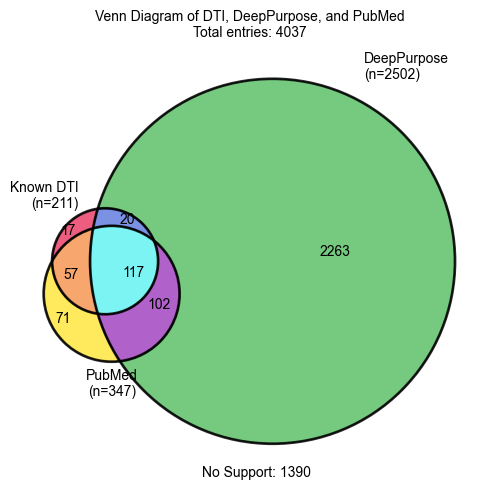

In [19]:
plt.rcParams["font.family"] = "Arial"
plt.rcParams["pdf.fonttype"] = 42
fontsize = 10
plt.rcParams["font.size"] = fontsize

# CSVファイルを読み込み
data = drug_gene.copy()

set_dti = set(data[data["dti_existed"] == 1].index)
set_deeppurpose = set(data[data["binary_deeppurpose"] == 1].index)
set_pubmed = set(data[data["pubmed_hit"] == True].index)

# 条件を定義（True/1の場合）
dti_condition = data["dti_existed"] == 1
deeppurpose_condition = data["binary_deeppurpose"] == 1
pubmed_condition = data["pubmed_hit"] == True

# 各条件の組み合わせを直接計算
# 8つの可能な組み合わせ
combo_000 = (
    ~dti_condition & ~deeppurpose_condition & ~pubmed_condition
).sum()  # どれもなし
combo_001 = (
    ~dti_condition & ~deeppurpose_condition & pubmed_condition
).sum()  # PubMedのみ
combo_010 = (
    ~dti_condition & deeppurpose_condition & ~pubmed_condition
).sum()  # DeepPurposeのみ
combo_011 = (
    ~dti_condition & deeppurpose_condition & pubmed_condition
).sum()  # DeepPurpose + PubMed
combo_100 = (
    dti_condition & ~deeppurpose_condition & ~pubmed_condition
).sum()  # DTIのみ
combo_101 = (
    dti_condition & ~deeppurpose_condition & pubmed_condition
).sum()  # DTI + PubMed
combo_110 = (
    dti_condition & deeppurpose_condition & ~pubmed_condition
).sum()  # DTI + DeepPurpose
combo_111 = (dti_condition & deeppurpose_condition & pubmed_condition).sum()  # 3つ全て

subsets = (
    combo_100,  # DTIのみ (Abc)
    combo_010,  # DeepPurposeのみ (aBc)
    combo_110,  # DTI+DeepPurpose (ABc)
    combo_001,  # PubMedのみ (abC)
    combo_101,  # DTI+PubMed (AbC)
    combo_011,  # DeepPurpose+PubMed (aBC)
    combo_111,  # 3つ全て (ABC)
)

# ベン図を作成
plt.figure(figsize=(6, 5))

# ベン図を描画
venn = venn3(
    subsets=subsets,
    set_labels=(
        "Known DTI\n(n={})".format(dti_condition.sum()),
        "DeepPurpose\n(n={})".format(deeppurpose_condition.sum()),
        "PubMed\n(n={})".format(pubmed_condition.sum()),
    ),
)

for text in venn.set_labels:
    if text:
        text.set_fontsize(fontsize)

for text in venn.subset_labels:
    if text:
        text.set_fontsize(fontsize)

# 円の境界線を追加
if venn:
    circles = venn3_circles(subsets=subsets, linewidth=2, alpha=0.8)

# 色を設定
if venn:
    # 単独の領域
    colors = {
        "100": color_list[0],  # DTIのみ
        "010": color_list[1],  # DeepPurposeのみ
        "001": color_list[2],  # PubMedのみ
        "110": color_list[3],  # DTI + DeepPurpose
        "101": color_list[4],  # DTI + PubMed
        "011": color_list[5],  # DeepPurpose + PubMed
        "111": color_list[6],  # 3つ全て
    }

    for region, color in colors.items():
        patch = venn.get_patch_by_id(region)
        if patch:
            patch.set_color(color)
            patch.set_alpha(0.7)
            patch.set_edgecolor("black")
            patch.set_linewidth(1)

# どれにも該当しない件数
total = len(df)
venn_included = set_dti | set_deeppurpose | set_pubmed
none_of_them = total - len(venn_included)
plt.text(
    0.4,
    0,
    f"No Support: {none_of_them}",
    fontsize=fontsize,
    transform=plt.gca().transAxes,
)

# タイトルを設定
plt.title(
    "Venn Diagram of DTI, DeepPurpose, and PubMed\n" f"Total entries: {len(data)}",
    fontsize=fontsize,
)

plt.tight_layout()
plt.savefig("venn_diagram/all.pdf", format="pdf", bbox_inches="tight")  # ← PDF保存
plt.show()

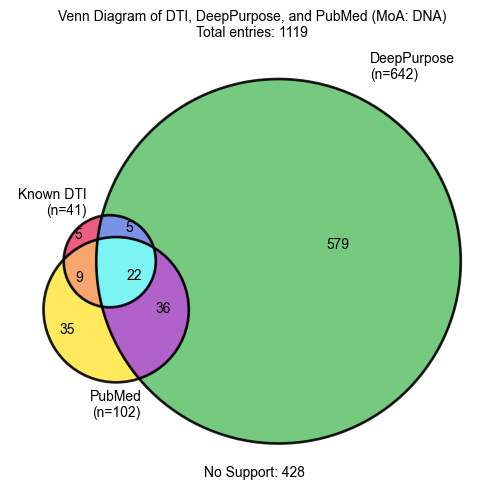

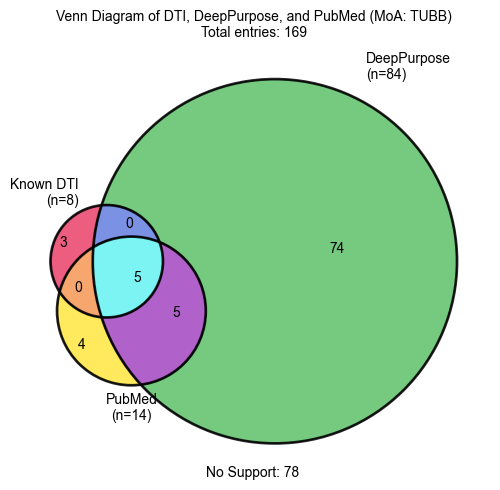

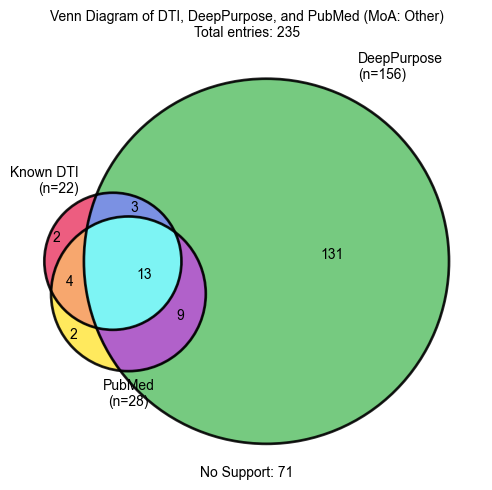

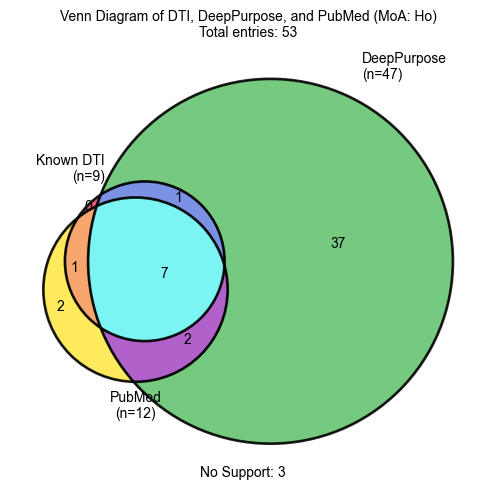

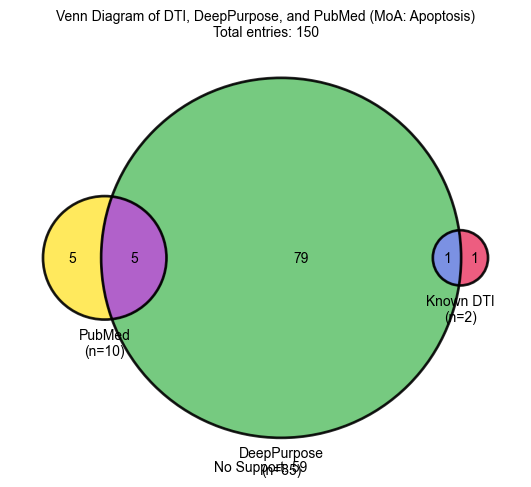

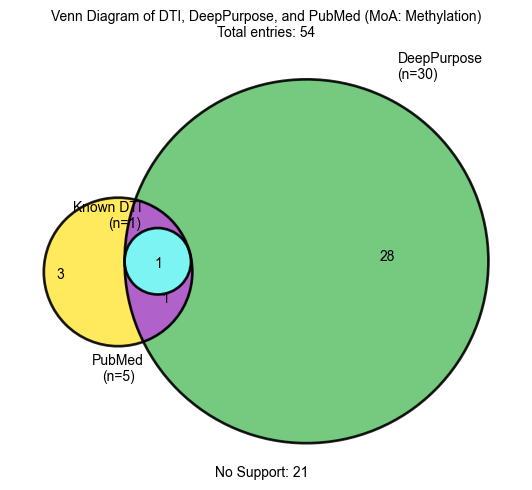

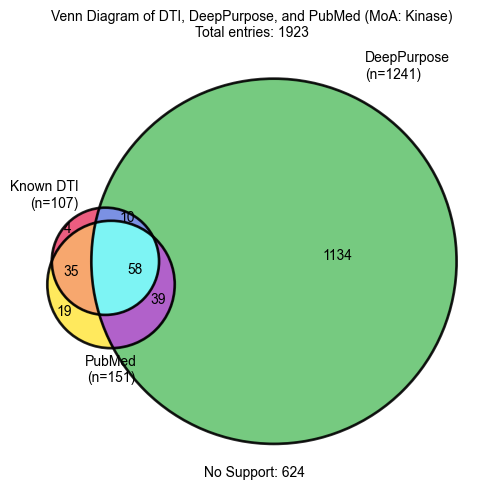

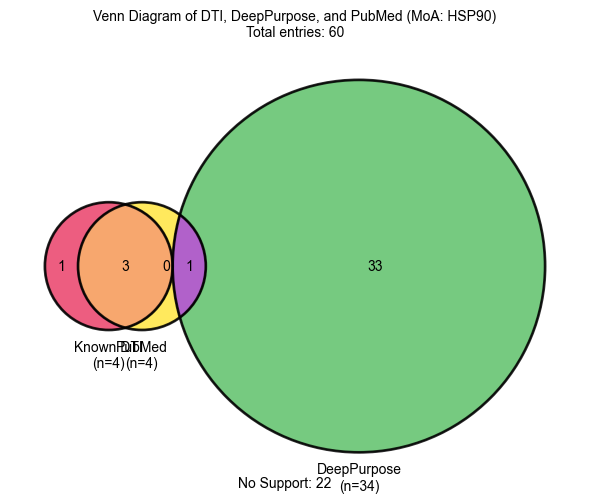

/Users/inouey2/miniconda3/envs/torch/lib/python3.10/site-packages/matplotlib_venn/layout/venn3/pairwise.py:169: UserWarning: Bad circle positioning.
  warnings.warn("Bad circle positioning.")


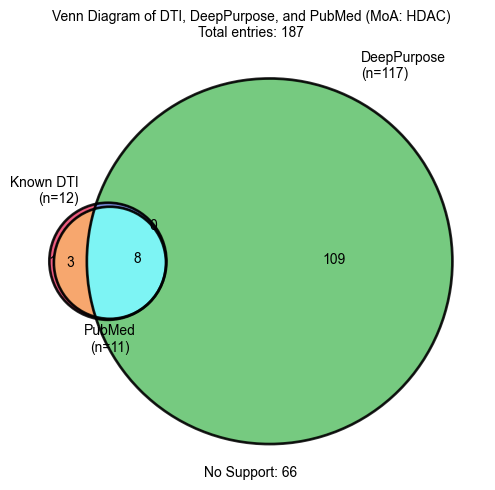

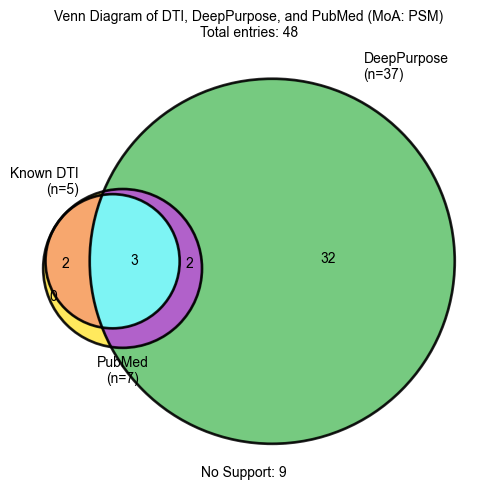

/Users/inouey2/miniconda3/envs/torch/lib/python3.10/site-packages/matplotlib_venn/layout/venn3/pairwise.py:103: UserWarning: Circle A has zero area.
  warnings.warn("Circle A has zero area.")


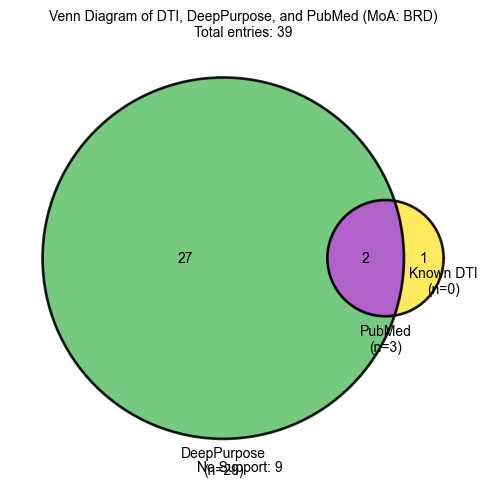

In [20]:
for i in drug_gene["MECHANISM"].unique():
    data = drug_gene[drug_gene["MECHANISM"] == i]

    set_dti = set(data[data["dti_existed"] == 1].index)
    set_deeppurpose = set(data[data["binary_deeppurpose"] == 1].index)
    set_pubmed = set(data[data["pubmed_hit"] == True].index)

    # 条件を定義（True/1の場合）
    dti_condition = data["dti_existed"] == 1
    deeppurpose_condition = data["binary_deeppurpose"] == 1
    pubmed_condition = data["pubmed_hit"] == True

    # 各条件の組み合わせを直接計算
    # 8つの可能な組み合わせ
    combo_000 = (
        ~dti_condition & ~deeppurpose_condition & ~pubmed_condition
    ).sum()  # どれもなし
    combo_001 = (
        ~dti_condition & ~deeppurpose_condition & pubmed_condition
    ).sum()  # PubMedのみ
    combo_010 = (
        ~dti_condition & deeppurpose_condition & ~pubmed_condition
    ).sum()  # DeepPurposeのみ
    combo_011 = (
        ~dti_condition & deeppurpose_condition & pubmed_condition
    ).sum()  # DeepPurpose + PubMed
    combo_100 = (
        dti_condition & ~deeppurpose_condition & ~pubmed_condition
    ).sum()  # DTIのみ
    combo_101 = (
        dti_condition & ~deeppurpose_condition & pubmed_condition
    ).sum()  # DTI + PubMed
    combo_110 = (
        dti_condition & deeppurpose_condition & ~pubmed_condition
    ).sum()  # DTI + DeepPurpose
    combo_111 = (
        dti_condition & deeppurpose_condition & pubmed_condition
    ).sum()  # 3つ全て

    subsets = (
        combo_100,  # DTIのみ (Abc)
        combo_010,  # DeepPurposeのみ (aBc)
        combo_110,  # DTI+DeepPurpose (ABc)
        combo_001,  # PubMedのみ (abC)
        combo_101,  # DTI+PubMed (AbC)
        combo_011,  # DeepPurpose+PubMed (aBC)
        combo_111,  # 3つ全て (ABC)
    )

    # ベン図を作成
    plt.figure(figsize=(6, 5))

    # ベン図を描画
    venn = venn3(
        subsets=subsets,
        set_labels=(
            "Known DTI\n(n={})".format(dti_condition.sum()),
            "DeepPurpose\n(n={})".format(deeppurpose_condition.sum()),
            "PubMed\n(n={})".format(pubmed_condition.sum()),
        ),
    )

    for text in venn.set_labels:
        if text:
            text.set_fontsize(fontsize)

    for text in venn.subset_labels:
        if text:
            text.set_fontsize(fontsize)

    # 円の境界線を追加
    if venn:
        circles = venn3_circles(subsets=subsets, linewidth=2, alpha=0.8)

    # 色を設定
    if venn:
        # 単独の領域
        colors = {
            "100": color_list[0],  # DTIのみ
            "010": color_list[1],  # DeepPurposeのみ
            "001": color_list[2],  # PubMedのみ
            "110": color_list[3],  # DTI + DeepPurpose
            "101": color_list[4],  # DTI + PubMed
            "011": color_list[5],  # DeepPurpose + PubMed
            "111": color_list[6],  # 3つ全て
        }

        for region, color in colors.items():
            patch = venn.get_patch_by_id(region)
            if patch:
                patch.set_color(color)
                patch.set_alpha(0.7)
                patch.set_edgecolor("black")
                patch.set_linewidth(1)

    # どれにも該当しない件数
    total = len(data)
    venn_included = set_dti | set_deeppurpose | set_pubmed
    none_of_them = total - len(venn_included)
    plt.text(
        0.4,
        0,
        f"No Support: {none_of_them}",
        fontsize=fontsize,
        transform=plt.gca().transAxes,
    )

    # タイトルを設定
    plt.title(
        f"Venn Diagram of DTI, DeepPurpose, and PubMed (MoA: {i})\n"
        f"Total entries: {len(data)}",
        fontsize=fontsize,
    )

    plt.tight_layout()
    plt.savefig(f"venn_diagram/{i}.pdf", format="pdf", bbox_inches="tight")  # ← PDF保存
    plt.show()

In [21]:
# # Prepare a dataset filtered for necessary fields and remove NaN
# viz_df = drug_gene[
#     ["MECHANISM", "gene", "dti_existed", "binary_deeppurpose", "pubmed_hit"]
# ].dropna()

# # Convert necessary fields to int
# viz_df["dti_existed"] = viz_df["dti_existed"].astype(int)
# viz_df["binary_deeppurpose"] = viz_df["binary_deeppurpose"].astype(int)
# viz_df["pubmed_hit"] = viz_df["pubmed_hit"].astype(int)


# # サポートカテゴリの定義（簡潔化）
# def categorize(row):
#     if row["dti_existed"] == 1:
#         return "Known DTI"
#     elif row["binary_deeppurpose"] == 1 and row["pubmed_hit"] == 1:
#         return "DP + PubMed"
#     elif row["binary_deeppurpose"] == 1:
#         return "DP Only"
#     elif row["pubmed_hit"] == 1:
#         return "PubMed Only"
#     else:
#         return "No Support"


# viz_df["prediction_category"] = viz_df.apply(categorize, axis=1)

# # クロス集計して割合に変換（行合計で正規化）
# support_counts = pd.crosstab(viz_df["MECHANISM"], viz_df["prediction_category"])
# support_percent = support_counts.div(support_counts.sum(axis=1), axis=0) * 100
# support_annot = support_percent.round(0).astype(int).astype(str) + "%"

# # Count categories
# category_counts = viz_df["prediction_category"].value_counts().reset_index()
# category_counts.columns = ["Prediction Category", "Count"]

# total_count = category_counts["Count"].sum()

# fig, (ax1, ax2) = plt.subplots(
#     1, 2, figsize=(12, 4), gridspec_kw={"width_ratios": [0.6, 1.8]}
# )

# # 横向きBarplot（棒の右に値を表示）
# sns.barplot(
#     data=category_counts.assign(Hue=category_counts["Prediction Category"]),
#     y="Prediction Category",
#     x="Count",
#     hue="Hue",
#     palette=color_list[: len(category_counts)],
#     ax=ax1,
# )
# ax1.set_xscale("log")
# ax1.set_xlim(10, category_counts["Count"].max() * 4.5)
# ax1.set_title(
#     "Distribution of AC-Suggested Drug–Gene Pairs\nby Evidence (Total: {:,})".format(
#         total_count
#     )
# )
# ax1.set_xlabel("Count (log scale)")
# ax1.set_ylabel("")

# # 各バーの横に値を表示
# for i, row in category_counts.iterrows():
#     ax1.text(
#         x=row["Count"] * 1.05,  # 少し右にずらす
#         y=i,
#         s=f"{int(row['Count']):,}",  # カンマ区切り
#         va="center",
#         fontsize=fontsize,
#     )

# # "Other" を右端に移動
# cols = support_percent.index.tolist()
# if "Other" in cols:
#     cols.remove("Other")
#     cols.append("Other")
# support_percent = support_percent.loc[cols]
# support_percent_t = support_percent.T
# support_annot_t = support_percent_t.round(0).astype(int).astype(str) + "%"

# # Heatmap on the right
# sns.heatmap(
#     support_percent_t,
#     annot=support_annot_t,
#     fmt="",
#     cmap="YlGnBu",
#     linewidths=0.5,
#     square=True,
#     cbar_kws={"shrink": 0.5, "pad": 0.01},
#     ax=ax2,
# )
# ax2.collections[0].colorbar.set_label("Proportion (%)")
# ax2.set_title("MoA-wise Breakdown of Supporting Evidence for AC-Suggested Targets")
# ax2.set_xlabel("")
# ax2.set_ylabel("")
# ax2.tick_params(axis="x", rotation=45)
# ax2.tick_params(axis="y")

# plt.tight_layout()
# plt.savefig("compWithDP.pdf", format="pdf", bbox_inches="tight")  # ← PDF保存
# plt.show()

- Remove Other
- 